In [1]:
%pip install ydata-profiling

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import ydata_profiling as pp

# Load your data
df = pd.read_csv('KaggleV2-May-2016.csv')


df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])

# Step 2 & 3: Create 'DayType' column
df['DayType'] = df['AppointmentDay'].dt.weekday.apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

# Preview the result
print(df[['AppointmentDay', 'DayType']].head())
# Drop specified columns
df.drop(columns=['PatientId', 'AppointmentID', 'ScheduledDay', 'AppointmentDay','Neighbourhood'], inplace=True)

# profile = pp.ProfileReport(df, title="Your Data Report")


             AppointmentDay  DayType
0 2016-04-29 00:00:00+00:00  Weekday
1 2016-04-29 00:00:00+00:00  Weekday
2 2016-04-29 00:00:00+00:00  Weekday
3 2016-04-29 00:00:00+00:00  Weekday
4 2016-04-29 00:00:00+00:00  Weekday


In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Step 3: Label encode 'No-show'
le = LabelEncoder()
df['No-show'] = le.fit_transform(df['No-show'])  # 'No' -> 0, 'Yes' -> 1

# Identify categorical columns (excluding 'No-show')
categorical_cols = df.select_dtypes(include='object').columns.tolist()
categorical_cols = [col for col in categorical_cols if col != 'No-show']

# One-hot encode the remaining categorical columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True,dtype=int)

# View the final result
df.head()

,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Gender_M,DayType_Weekend
0,62,0,1,0,0,0,0,0,0,0
1,56,0,0,0,0,0,0,0,1,0
2,62,0,0,0,0,0,0,0,0,0
3,8,0,0,0,0,0,0,0,0,0
4,56,0,1,1,0,0,0,0,0,0


In [4]:
# Calculate correlation with respect to 'No-show'
correlations = df.corr(numeric_only=True)['No-show'].sort_values(ascending=False)

# Display the result
print(correlations)


No-show            1.000000
SMS_received       0.126431
Scholarship        0.029135
DayType_Weekend    0.001350
Alcoholism        -0.000196
Gender_M          -0.004119
Handcap           -0.006076
Diabetes          -0.015180
Hipertension      -0.035701
Age               -0.060319
Name: No-show, dtype: float64


In [5]:
# Compute correlations with the target
correlations = df.corr(numeric_only=True)['No-show'].abs()

# Select features with correlation ≥ 0.01
useful_features = correlations[correlations >= 0.01].index.tolist()

# Ensure 'No-show' remains in the dataset
if 'No-show' not in useful_features:
    useful_features.append('No-show')

# Filter the DataFrame
df = df[useful_features]
df


,Age,Scholarship,Hipertension,Diabetes,SMS_received,No-show
0,62,0,1,0,0,0
1,56,0,0,0,0,0
2,62,0,0,0,0,0
3,8,0,0,0,0,0
4,56,0,1,1,0,0
...,...,...,...,...,...,...
110522,56,0,0,0,1,0
110523,51,0,0,0,1,0
110524,21,0,0,0,1,0
110525,38,0,0,0,1,0


In [6]:
from sklearn.model_selection import train_test_split

# Separate features (X) and target (y)
X = df.drop('No-show', axis=1)
y = df['No-show']

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Train Accuracy: 0.5869872541590798
Test Accuracy: 0.5853162037455895
F1 Score (Test): 0.35899587441437664
Confusion Matrix (Test):
 [[10372  7270]
 [ 1897  2567]]


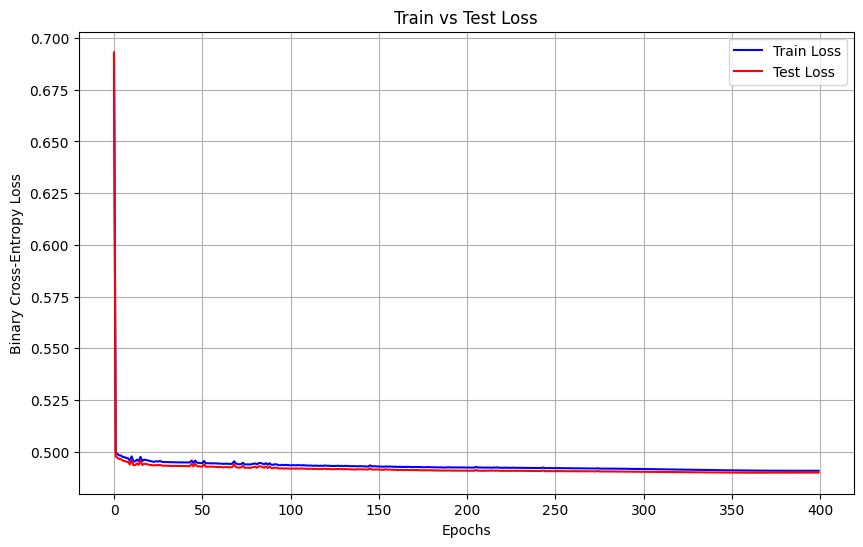

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df['Age'] = scaler.fit_transform(df[['Age']])

# ----- Prepare the data -----
X = df.drop('No-show', axis=1)
y = df['No-show']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ----- Helper functions -----
def get_class_weights(y):
    weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
    return {i: weight for i, weight in enumerate(weights)}

def initialize_parameters(layer_dims):
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l-1], layer_dims[l]) * 0.1
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
    return parameters

def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

def sigmoid_derivative(Z):
    s = sigmoid(Z)
    return s * (1 - s)

def linear_forward(A_prev, W, b, activation):
    Z = np.dot(W.T, A_prev) + b
    if activation == "relu":
        A = relu(Z)
    elif activation == "sigmoid":
        A = sigmoid(Z)
    else:
        raise ValueError("Unsupported activation: " + activation)
    cache = (A_prev, W, b, Z, activation)
    return A, cache
def relu(Z):
    return np.maximum(0, Z)

def relu_derivative(Z):
    return (Z > 0).astype(float)


def L_layer_forward(X, parameters):
    A = X
    caches = []
    L = len(parameters) // 2

    for l in range(1, L):
        A_prev = A
        W = parameters['W' + str(l)]
        b = parameters['b' + str(l)]
        A, cache = linear_forward(A_prev, W, b, activation="relu")
        caches.append(cache)

    # Output layer with sigmoid
    W = parameters['W' + str(L)]
    b = parameters['b' + str(L)]
    A, cache = linear_forward(A, W, b, activation="sigmoid")
    caches.append(cache)

    return A, caches


def compute_loss(y, y_hat):
    m = y.shape[1]
    loss = -np.sum(y * np.log(y_hat + 1e-8) + (1 - y) * np.log(1 - y_hat + 1e-8)) / m
    return loss

def update_parameters(parameters, caches, y_true, y_hat, learning_rate, class_weight):
    L = len(caches)
    m = y_hat.shape[1]
    dA = -(class_weight) * (y_true / y_hat - (1 - y_true) / (1 - y_hat))

    for l in reversed(range(L)):
        A_prev, W, b, Z, activation = caches[l]
        
        if activation == "relu":
            dZ = dA * relu_derivative(Z)
        elif activation == "sigmoid":
            dZ = dA * sigmoid_derivative(Z)
        
        dW = np.dot(A_prev, dZ.T)
        db = np.sum(dZ, axis=1, keepdims=True)
        dA = np.dot(W, dZ)
        parameters['W' + str(l+1)] -= learning_rate * dW
        parameters['b' + str(l+1)] -= learning_rate * db


# ----- Training setup -----
layer_dims = [X_train.shape[1], 80, 2, 1]  # Increased complexity
parameters = initialize_parameters(layer_dims)
class_weights = get_class_weights(y_train)
class_weights[1] *= 30 # Amplify minority class

train_losses = []
test_losses = []

initial_lr = 0.001
final_lr = 0.00001
epochs = 400
batch_size = 200

# ----- Training loop -----
for i in range(epochs):
    # Linear LR decay
    learning_rate = initial_lr - ((initial_lr - final_lr) / epochs) * i

    # Full forward pass
    y_hat_train, _ = L_layer_forward(X_train.T, parameters)
    y_hat_test, _ = L_layer_forward(X_test.T, parameters)

    # Compute and store loss
    train_loss = compute_loss(y_train.values.reshape(1, -1), y_hat_train)
    test_loss = compute_loss(y_test.values.reshape(1, -1), y_hat_test)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    # Batch updates
    n_batches = X_train.shape[0] // batch_size
    for batch in range(n_batches):
        start = batch * batch_size
        end = start + batch_size
        x_batch = X_train.iloc[start:end].values.T
        y_batch = y_train.iloc[start:end].values.reshape(1, -1)
        y_hat_batch, caches = L_layer_forward(x_batch, parameters)
        weights = np.array([class_weights[y] for y in y_batch.flatten()])
        avg_weight = np.average(weights)
        update_parameters(parameters, caches, y_batch, y_hat_batch,
                          learning_rate=learning_rate, class_weight=avg_weight)

# ----- Evaluation -----
y_hat_train_final, _ = L_layer_forward(X_train.T, parameters)
y_hat_test_final, _ = L_layer_forward(X_test.T, parameters)
y_pred_train = (y_hat_train_final.flatten() > 0.19).astype(int)
y_pred_test = (y_hat_test_final.flatten() > 0.19).astype(int)

print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("F1 Score (Test):", f1_score(y_test, y_pred_test, zero_division=0))
print("Confusion Matrix (Test):\n", confusion_matrix(y_test, y_pred_test))

# ----- Loss plot -----
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Train Loss", color='blue')
plt.plot(test_losses, label="Test Loss", color='red')
plt.xlabel("Epochs")
plt.ylabel("Binary Cross-Entropy Loss")
plt.title("Train vs Test Loss")
plt.legend()
plt.grid(True)
plt.show()
